# TP OpenMP - October 2022
## Part 1 : Pi
### Compilation

In [12]:
!g++ -o binaries/tp_openmp_part_1_pi binaries/tp_openmp_part_1_pi.cpp -fopenmp -O3 -march=native
!g++ -o binaries/tp_openmp_part_1_pi_impl_reduce binaries/tp_openmp_part_1_pi_impl_reduce.cpp -fopenmp -O3 -march=native
!g++ -o binaries/tp_openmp_part_1_pi_impl_atomic binaries/tp_openmp_part_1_pi_impl_atomic.cpp -fopenmp -O3 -march=native
!g++ -o binaries/tp_openmp_part_1_pi_impl_critical binaries/tp_openmp_part_1_pi_impl_critical.cpp -fopenmp -O3 -march=native
!g++ -o binaries/tp_openmp_part_1_pi_splitArray binaries/tp_openmp_part_1_pi_splitArray.cpp -fopenmp -O3 -march=native

### Performance evaluation

In [5]:
num_steps = [10000, 1000000, 100000000]
algo_compare = ['Sequentiel', 'Reduce', 'Atomic', 'Critical', 'Split_array']
nb_core = [1, 2, 4, 8]


In [13]:
import os
import subprocess

try:
    os.remove("../pi_Stats.csv")
    f=open("../pi_Stats.csv","w+")
    f.write("version,num_steps,nbcore,runtime,pi\n")
    f.close()
except OSError:
    pass

repeats = range(0,10)

for nsteps in num_steps:
    for ncore in nb_core:
        for repeat in repeats:
            args = ("binaries/tp_openmp_part_1_pi", "-C", str(ncore), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            args = ("binaries/tp_openmp_part_1_pi_impl_critical", "-C", str(ncore), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            args = ("binaries/tp_openmp_part_1_pi_impl_reduce", "-C", str(ncore), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            args = ("binaries/tp_openmp_part_1_pi_impl_atomic", "-C", str(ncore), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            args = ("binaries/tp_openmp_part_1_pi_splitArray", "-C", str(ncore), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()



### Performance analysis
#### Weak scaling

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../pi_Stats.csv',header=0,dtype={
                    'version': str,
                    'nbcore': "int64",
                    'num_steps' : "int64",
                    'runtime' : "float64",
                    'pi' : "float64"
                 }
                 )
    
color_num_steps = {10000 : "blue", 1000000 : "red", 100000000 : "green", 10000000000 : "black"}
color_algo = {"Sequentiel" : "blue", "Reduce" : "red", "Atomic" : "green", "Critical" : "black", "Split_array" : "orange"}
color_core = {1 : "blue", 2 : "red", 3 : "green", 4 : "black", 5 : "orange", 6 : "yellow", 7 : "purple", 8 : "brown"}

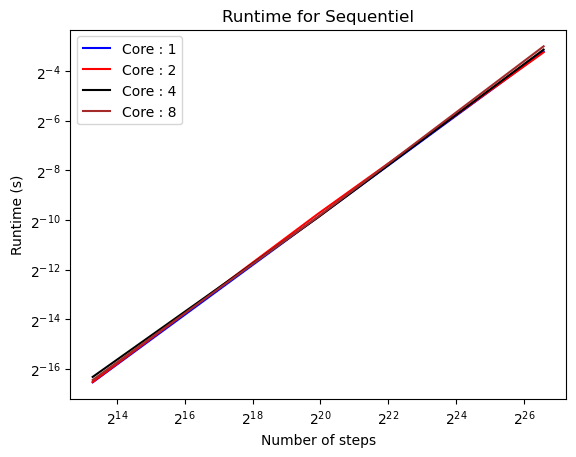

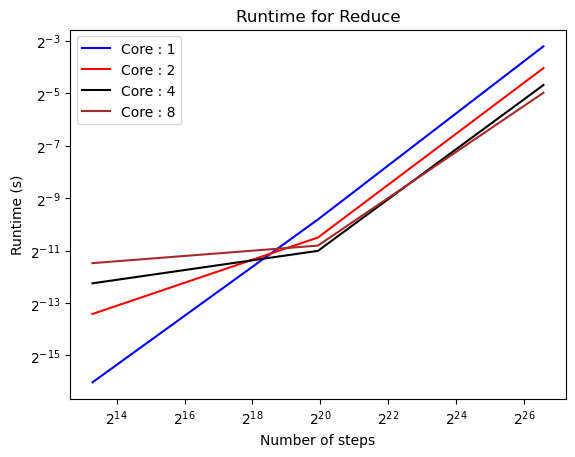

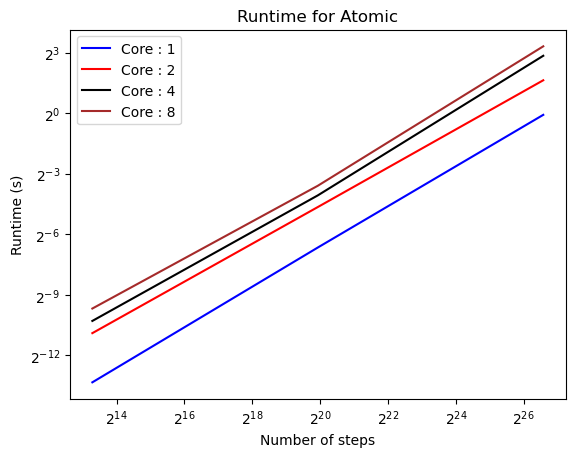

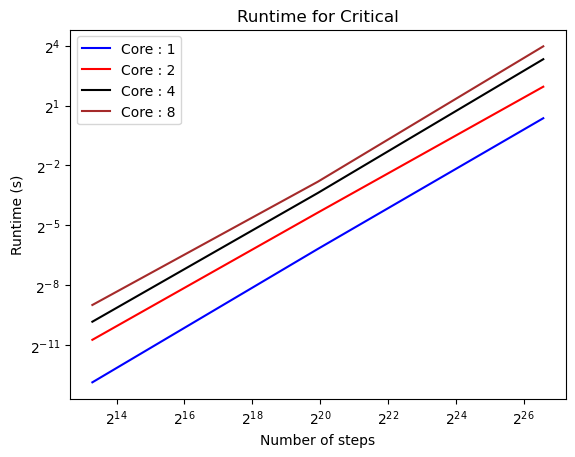

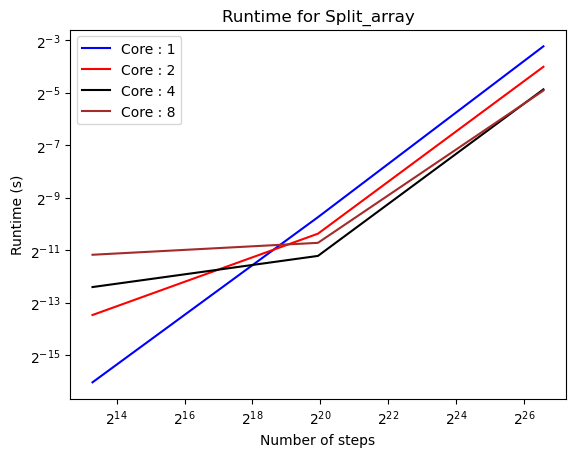

In [31]:
for algo in algo_compare:
    df_algo = df[df['version'] == algo]
    mean = df_algo.groupby(['nbcore', "num_steps"]).mean().reset_index()
    for core in nb_core:
        df_core = mean[mean['nbcore'] == core]
        plt.plot(df_core['num_steps'], df_core['runtime'], color=color_core[core], label="Core : " + str(core))
    plt.legend()
    plt.title("Runtime for " + algo)
    plt.xlabel("Number of steps")
    plt.ylabel("Runtime (s)")
    plt.yscale('log')
    plt.xscale('log')
    plt.show()




On peux remarqué que le nombre de core n'affecte pas le temps d'éxécution du premier programme. Cela est dû au fait que le programme est séquentiel. De plus, les algorithmes utilisant les directives atomic et critical sont moins performantes parralélisés que séquentiel (1 core). Cela est dû au fait que les threads sont limité par le temps de lock et unlock des variables partagées (sum). Enfin, pour les algorithmes reduce et splitarray, prévu pour ce cas de figure, on remarque que le temps d'éxécution est réduit à chaque fois qu'on augmente le nombre de core, mais seulement à partir d'un certain nombre de données (steps), indiquant que la parralélisation est efficace (si le nombre de données est trop petit, la latence prends le pas sur le throughout et le temps d'éxécution augmente).

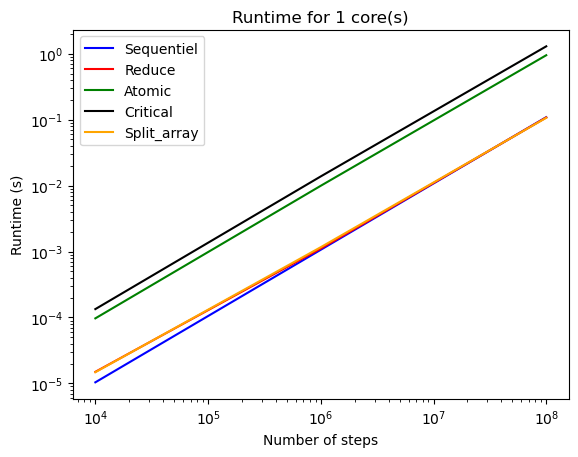

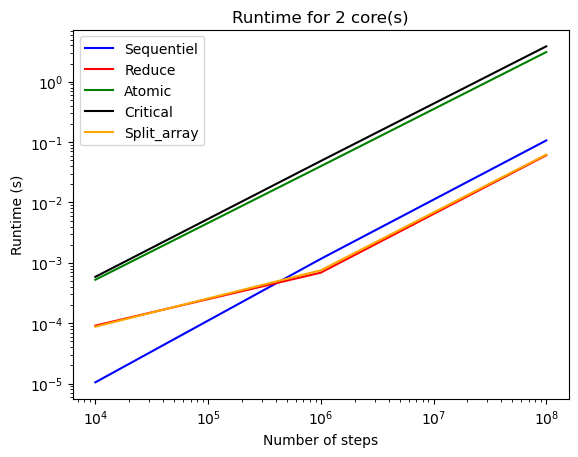

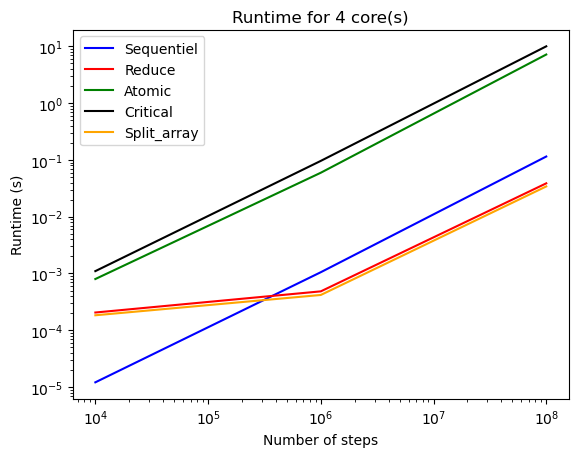

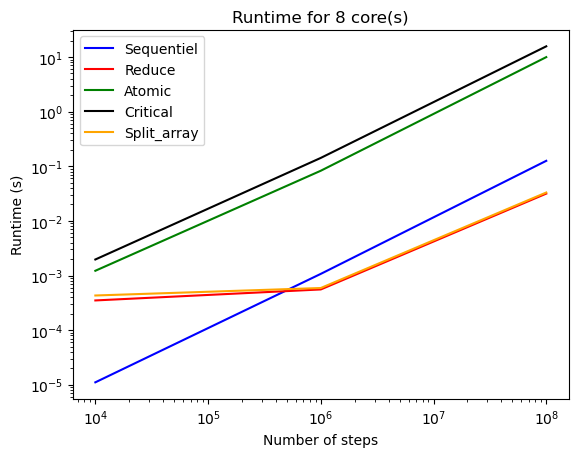

In [9]:
for core in nb_core:
    df_core = df[df['nbcore'] == core]
    mean = df_core.groupby(['version', "num_steps"]).mean().reset_index()
    for algo in algo_compare:
        df_algo = mean[mean['version'] == algo]
        plt.plot(df_algo['num_steps'], df_algo['runtime'], color=color_algo[algo], label=algo)
    plt.legend()
    plt.title("Runtime for " + str(core) + " core(s)")
    plt.xlabel("Number of steps")
    plt.ylabel("Runtime (s)")
    plt.yscale('log')
    plt.xscale('log')
    plt.show()

On peux voir que les algorithmes atomic et critical sont moins performants que les autres algorithmes dans tout les cas, pour la même raison que précédemment. De plus, les algorithmes reduce et splitarray sont quasiment équivalent en terme de temps d'éxécution, ce qui est logique car l'algorithme de Split Array est une version moins optimisé de l'algorithme Reduce. Enfin, l'algorithme séquentiel est plus performant que les autres algorithmes, lorsque le nombre de données est petit, ce qui est logique car la latence prends le pas sur le throughout.
